In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from seirsplus.models import *
from seirsplus.networks import *
from seirsplus.sim_loops import *
from seirsplus.utilities import *
from network_utils import *
from stats_utils import *
from intervention_utils import *
from camp_params import *
import pickle as pkl
from littleballoffur import RandomNodeSampler, DegreeBasedSampler, PageRankBasedSampler

In [2]:
# TODO: Update this in model_server
def link_nodes_by_activity(base_graph, nodes_per_struct, percentage_per_struct, proximity_radius, edge_weight,
                           activity_name):
    """ Connect a given percentage of nodes per structure that engage in the same activity
        with other nodes from different structures that engage in the same activity, at a given proximity radius
        Examples of activities:
        - Food queue
        - Religious events
    """
    graph = base_graph.copy()

    activity_bois = set()

    # Choose a percentage of people randomly from each structure
    for node_list in nodes_per_struct:
        if len(node_list) == 1:
            activity_bois.add(node_list[0])
        else:
            for i in range(int(len(node_list) * percentage_per_struct)):
                activity_bois.add(np.random.choice(node_list))

    activity_bois = list(activity_bois)
    np.random.shuffle(activity_bois)

    # Draw an edge between everyone in the list within a given proximity
    for i in range(len(activity_bois) - proximity_radius):
        for j in range(i + 1, i + proximity_radius + 1):
            if not graph.has_edge(activity_bois[i], activity_bois[j]):
                graph.add_edge(
                    activity_bois[i],
                    activity_bois[j],
                    weight=edge_weight,
                    label=activity_name)
    return graph

In [3]:
n_pop = 18700

# Grid info for isoboxes
dims_isoboxes = (29, 28)  # 812

# Grid info for tents
dims_block1 = (20, 67)  # 1340
dims_block2 = (53, 15)  # 795
dims_block3 = (19, 28)  # 532

# Isoboxes
pop_isoboxes = 8100
pop_per_isobox = 10
n_isoboxes = dims_isoboxes[0]*dims_isoboxes[1]

# Tents
n_tents = 2650
pop_tents = 10600
pop_per_tent = 4

# Others 
n_bathrooms = 144
n_ethnic_groups = 8

# We define neighboring structures within a range of 2 in the structure grid
proximity = 2

# Define the maximum population per structures (tents and isoboxes) drawn from a poisson distribution
max_pop_per_struct = list(poisson.rvs(mu=pop_per_isobox, size=n_isoboxes))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block1[0]*dims_block1[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block2[0]*dims_block2[1]))
max_pop_per_struct = max_pop_per_struct + list(poisson.rvs(mu=pop_per_tent, size=dims_block3[0]*dims_block3[1]))

n_structs = len(max_pop_per_struct)

# Sample the population age, and parameter rates
sample_pop = sample_population(n_pop, "data/augmented_population.csv")

In [4]:
# graph, nodes_per_struct = load_graph("experiments/networks/Moria_wNeighbors_4")

household_weight = 0.98
graph, nodes_per_struct = create_graph(n_structs, 0, n_pop, max_pop_per_struct, 
                                       edge_weight=household_weight, label="household",
                                       age_list=list(sample_pop["age"]),
                                       sex_list = list(sample_pop["sex"]),
                                       n_ethnicities=n_ethnic_groups)

100%|██████████| 18700/18700 [00:16<00:00, 1106.12it/s]


In [5]:
food_weight = 0.407
# graph_1fq = connect_food_queue(graph, nodes_per_struct, food_weight, "food")
graph_1fq = link_nodes_by_activity(graph, nodes_per_struct, percentage_per_struct=0.5, proximity_radius=5, edge_weight=food_weight, activity_name="food")

In [6]:
neighbor_weight = 0.017

graph_1fq = link_nodes_by_property(graph_1fq, 0, n_isoboxes, nodes_per_struct,
                              grid_isoboxes, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_isoboxes[0]*dims_isoboxes[1], dims_block1[0]*dims_block1[1], nodes_per_struct,
                              grid_block1, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block1[0]*dims_block1[1], dims_block2[0]*dims_block2[1], nodes_per_struct,
                              grid_block2, 2, "ethnicity", neighbor_weight, 'friendship')
graph_1fq = link_nodes_by_property(graph_1fq, dims_block2[0]*dims_block2[1], dims_block3[0]*dims_block3[1], nodes_per_struct,
                              grid_block3, 2, "ethnicity", neighbor_weight, 'friendship')

Total pop:
Degree: mean = 22.59, std = 15.62, 95% CI = (2.00, 49.00)
        coeff var = 0.69
Assortativity:    0.02
Clustering coeff: 0.41



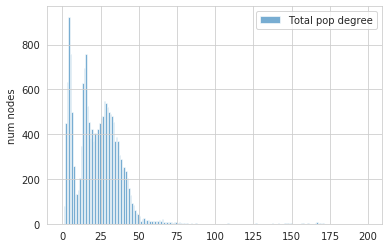

In [7]:
network_info(graph_1fq, "Total pop", plot=True)

Random Node Sampler:
Degree: mean = 5.68, std = 4.48, 95% CI = (0.00, 14.00)
        coeff var = 0.79
Assortativity:    0.02
Clustering coeff: 0.27



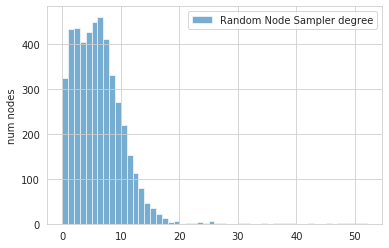

In [12]:
sub_graph = RandomNodeSampler(number_of_nodes=int(n_pop / 4)).sample(graph_1fq)

network_info(sub_graph, "Random Node Sampler", plot=True)

Degree Based Sampler:
Degree: mean = 10.65, std = 6.91, 95% CI = (1.00, 23.00)
        coeff var = 0.65
Assortativity:    0.05
Clustering coeff: 0.26



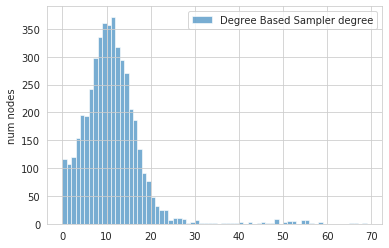

In [13]:
sub_graph = DegreeBasedSampler(number_of_nodes=int(n_pop / 4)).sample(graph_1fq)

network_info(sub_graph, "Degree Based Sampler", plot=True)

Page Rank Based Sampler:
Degree: mean = 6.56, std = 4.59, 95% CI = (0.00, 16.00)
        coeff var = 0.70
Assortativity:    0.07
Clustering coeff: 0.29



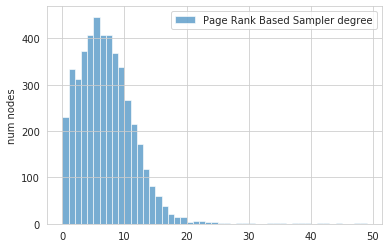

In [15]:
sub_graph = PageRankBasedSampler(number_of_nodes=int(n_pop / 4)).sample(graph_1fq)

network_info(sub_graph, "Page Rank Based Sampler", plot=True)

In [16]:
from littleballoffur.exploration_sampling import LoopErasedRandomWalkSampler, BreadthFirstSearchSampler, DepthFirstSearchSampler

from littleballoffur.exploration_sampling import CommunityStructureExpansionSampler, CirculatedNeighborsRandomWalkSampler, SnowBallSampler
from littleballoffur.exploration_sampling import RandomWalkSampler, MetropolisHastingsRandomWalkSampler, CommonNeighborAwareRandomWalkSampler
from littleballoffur.exploration_sampling import NonBackTrackingRandomWalkSampler, RandomWalkWithRestartSampler, ForestFireSampler, SpikyBallSampler

from littleballoffur.exploration_sampling import ShortestPathSampler, RandomWalkWithJumpSampler, FrontierSampler, RandomNodeNeighborSampler

Random Walk Sampler:
Degree: mean = 13.05, std = 7.31, 95% CI = (3.00, 28.00)
        coeff var = 0.56
Assortativity:    0.06
Clustering coeff: 0.30



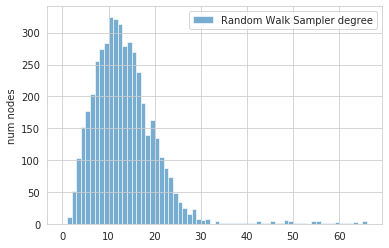

In [18]:
sub_graph = RandomWalkSampler(number_of_nodes=int(n_pop / 4)).sample(graph_1fq)

network_info(sub_graph, "Random Walk Sampler", plot=True)

Random Jump Sampler:
Degree: mean = 11.22, std = 7.05, 95% CI = (2.00, 25.00)
        coeff var = 0.63
Assortativity:    0.06
Clustering coeff: 0.31



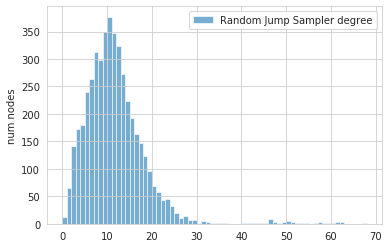

In [19]:
sub_graph = RandomWalkWithJumpSampler(number_of_nodes=int(n_pop / 4)).sample(graph_1fq)

network_info(sub_graph, "Random Jump Sampler", plot=True)